In [ ]:
!nvidia-smi

Tue Jun  7 10:30:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   3622MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir Images

In [ ]:
!cp "/content/drive/MyDrive/makerere/Images.zip" -r "/content"

In [ ]:
!unzip '/content/Images.zip' -d '/content/Images/'

In [ ]:
!pip install efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e14be6d707fc6252aef5c464d810f0b2c62d14b8be48a9dfd16644c0bf104da2
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
!git clone https://github.com/clovaai/rexnet.git

Cloning into 'rexnet'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 111 (delta 25), reused 19 (delta 19), pack-reused 79
Receiving objects: 100% (111/111), 36.46 KiB | 557.00 KiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 2.2 MB/s 


In [ ]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 3.0 MB/s 
     |████████████████████████████████| 47.8 MB 1.9 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install opencv-python-headless==4.2.0.34

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.4 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision import transforms
import torch
import timm
import torchvision
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd 
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm_notebook as tqdm 
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [ ]:
# for the directories and files operations & for system operations
import os 
import sys 
import glob
import zipfile

# for operations on images 
import cv2 
from PIL import  Image


# for some maths operations
import math
import random
import numpy as np

import pandas as pd

# Machine learning libs
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss


# pytorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

#Keras 
# from keras.utils import to_categorical

# others ibraries
from tqdm import tqdm_notebook as tqdm 
# from tqdm.notebook import tqdm # for progressBar

import IPython.display as ipd
from matplotlib import pyplot as plt # for visualization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
PATHS = {
    'cwd': './', #Current directory
    'arch': 'MODELS/', #Folder in which we're going to save our models
    'raw': '../Data/', #Folder containing the training files
    'images': 'images/' #this folder is going to store our images files
    }

os.makedirs(PATHS['arch'], exist_ok=True)

In [ ]:
seed = 2022 # for reproductibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, df, task='train', size=(300, 230), use_tfms=True, **kwargs):
        super(MaskDataset, self).__init__()
        self.df = df
        self.task = task
        self.size = size
        self.use_tfms = use_tfms
        self.c = 2

        self.train_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop((384, 384)),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.9, contrast=0.9, saturation=0.9, hue=0.45),
#             transforms.FiveCrop([384, 384])
#             transforms.CenterCrop((300, 300)),
            transforms.RandomEqualize(p=1.0),
            transforms.ToTensor(),
        ])
        self.transforms = transforms.Compose([
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fn = self.df.loc[idx, 'file_name']

        img = cv2.imread(fn)
        img = cv2.resize(img, self.size)

        if self.use_tfms: spec = self.train_transforms(img)
        img = self.transforms(img)

        output = {
              'image': img,
          }

        if self.task == 'train':
            label = self.df.loc[idx, 'target']
            output.update({
              'label': torch.tensor(label, dtype=torch.long)
          })

        return output

In [ ]:
import torch.nn.functional as F
class MaskModel(nn.Module):
    def __init__(self, name):
        super(MaskModel, self).__init__()
        self.name  = name
        if name == 'b0':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b0')
          self.arch._fc = nn.Linear(in_features=1280, out_features=3, bias=True)
        elif name == 'b1':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b1')
          self.arch._fc = nn.Linear(in_features=1280, out_features=3, bias=True)
        elif name == 'b2':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b2')
          self.arch._fc = nn.Linear(in_features=1408, out_features=3, bias=True)
        elif name =='b3':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b3')
          self.arch._fc = nn.Linear(in_features=1536, out_features=3, bias=True)
        elif name =='b4':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b4')
          self.arch._fc = nn.Linear(in_features=1792, out_features=3, bias=True)
        elif name =='b5':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b5')
          self.arch._fc = nn.Linear(in_features=2048, out_features=3, bias=True)
        elif name =='b6':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b6')
          self.arch._fc = nn.Linear(in_features=2304, out_features=3, bias=True)
        elif name =='b7':
          self.arch =  EfficientNet.from_pretrained('efficientnet-b7')
          self.arch._fc = nn.Linear(in_features=2560, out_features=3, bias=True)
        elif name == 'densenet121':
          self.arch = models.densenet121(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'densenet169':
          self.arch = models.densenet169(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'densenet201':
          self.arch = models.densenet201(pretrained=True)
          num_ftrs = self.arch.classifier.in_features
          self.arch.classifier = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'resnet50':
          self.arch = models.resnet50(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'resnet101':
          self.arch = models.resnet101(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'resnet152':
          self.arch = models.resnet152(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'resnet34':
          self.arch = models.resnet34(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'resnext101':
          self.arch = models.resnext101_32x8d(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          self.arch.fc = nn.Linear(num_ftrs,3,bias=True)
        elif name == 'resnext50':
          self.arch = models.resnext50_32x4d(pretrained=True)
          num_ftrs = self.arch.fc.in_features
          
          self.arch.fc = nn.Linear(num_ftrs,3,bias=True)
        elif name =='rexnetv1':
            model = rexnetv1.ReXNetV1(width_mult=1.0)
            model.output.conv2D = nn.Conv2d(1280, 3, kernel_size=(1, 1), stride=(1, 1))
      
        elif name == 'ig_resnext101_32x8d':
          self.arch = timm.create_model("ig_resnext101_32x8d", pretrained=True,  num_classes=3)
        
        elif name == 'gluon_seresnext101_32x4d':
          self.arch = timm.create_model("gluon_seresnext101_32x4d", pretrained=True,  num_classes=3)

        elif name == 'swin_base_patch4_window12_384_in22k':
          self.arch = timm.create_model("swin_base_patch4_window12_384_in22k", pretrained=True,  num_classes=3)
      
    def forward(self, x):
        x = self.arch(x)
        return x

In [ ]:
                ################## training Function ####################   
def training_fn(dataloader, model, opt, criterion, epoch):
    avg_loss = 0
    avg_acc = 0
    # pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}')
    model.to(device)

    
    model.train()

    for i, data in enumerate(dataloader):
        x,y = data['image'].to(device), data['label'].to(device)

        opt.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)
        pred = F.softmax(pred, dim=1)

        avg_loss += loss
        avg_acc += (y == pred.argmax(1)).float().mean()

        loss.backward()
        opt.step()

    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()
    print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader)))

In [ ]:
                    ################## evaluation Function ####################   

def evaluate(dataloader, model, criterion):
    avg_loss = 0
    avg_acc = 0
    avg_logloss = 0
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            x = data['image'].to(device)
            y = data['label'].to(device)

            pred = model(x)

            avg_loss += criterion(pred, y)
            pred = F.softmax(pred, dim=1)
            avg_acc += (y == pred.argmax(1) ).float().mean()

        avg_loss /= len(dataloader)
        avg_acc /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f}'.format(avg_loss.cpu().detach().numpy(), 
                                                    avg_acc.cpu().detach().numpy()))

    return avg_loss

In [ ]:
                ################## prediction Function ####################   
def predict(df, size, MODELS, bs=8):
    test_ds = MaskDataset(df, task='test', size=size, use_tfms=False)
    testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

    predictions_labels = []
    predictions_proba = []

    out = None

    for data in tqdm(testloader):
        x = data['image'].to(device)

        for i in range(n_folds):
            if i == 0: out = F.softmax(MODELS[i](x), dim=-1)
            else: out += F.softmax(MODELS[i](x), dim=-1)

        out /= n_folds
        out_labels = out.argmax(1).cpu().detach().numpy()
        out_probas = out.cpu().detach().numpy()

        predictions_labels += out_labels.tolist()
        predictions_proba += out_probas.tolist()

    return predictions_labels ,predictions_proba

In [ ]:
def run_fold(fold, bs=16, NAME='b2',
             eval_bs=8, 
             lr=1e-4, 
             size=(300, 230), 
             path=PATHS['arch']):
    
    best_logloss = np.inf

    fold_train = train[train.fold != fold].reset_index(drop=True)
    fold_val = train[train.fold == fold].reset_index(drop=True)

    train_ds = MaskDataset(fold_train, size=size)
    val_ds = MaskDataset(fold_val, size=size, use_tfms=False)

    trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
    validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

    model = MaskModel(NAME)
    criterion = torch.nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
  

    loader = tqdm(range(epochs), desc='Training')

    for epoch in loader:
        training_fn(trainloader, model, opt, criterion, epoch)
        avg_logloss = evaluate(validloader, model, criterion)

        if avg_logloss < best_logloss:
            best_logloss = avg_logloss
            torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

    return best_logloss

In [ ]:
def load_models(NAME='b2', 
                layer='fc', 
                fc_size=512,  
                path=PATHS['arch']):
    
    MODELS = []
    
    for i in range(n_folds):
        MODELS.append( MaskModel(NAME))
        MODELS[i].to(device)
        MODELS[i].load_state_dict(torch.load(f'{path}model_state_dict_{i}.bin'))
        MODELS[i].eval()
        
    return MODELS

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/makerere/Train.csv')
train = train.rename(columns = {'Image_id':'images','Label':'target'})
train.head()

,images,target
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [ ]:
train_images_list = train['images'].tolist() #convert images column into list

images_list = os.listdir('/content/Images')
# Add file names
train['file_name'] = '/content/Images/'+train['images']
# sub['file_name'] = './Images/'+sub['Image_id']

In [ ]:
train.head()

,images,target,file_name
0,id_02amazy34fgh2.jpg,1,/content/Images/id_02amazy34fgh2.jpg
1,id_02mh3w48pmyc9.jpg,0,/content/Images/id_02mh3w48pmyc9.jpg
2,id_02rpb463h9d3w.jpg,0,/content/Images/id_02rpb463h9d3w.jpg
3,id_02wc3jeeao8ol.jpg,1,/content/Images/id_02wc3jeeao8ol.jpg
4,id_03t2hapb8wz8p.jpg,1,/content/Images/id_03t2hapb8wz8p.jpg


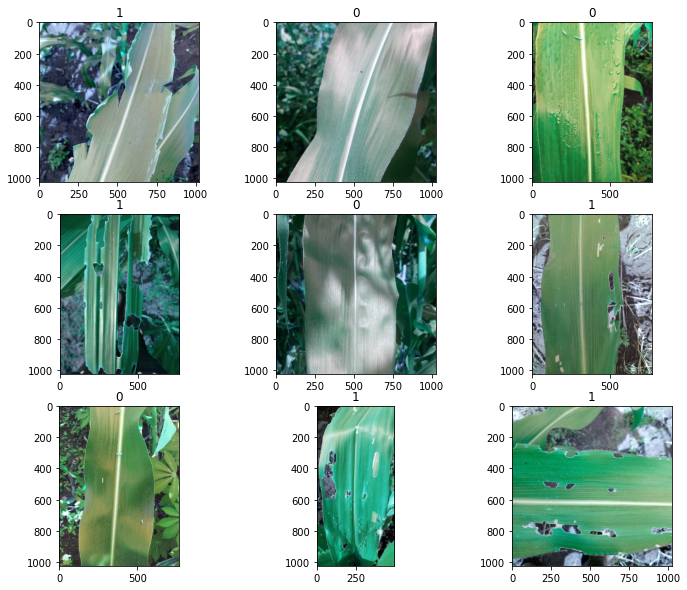

In [ ]:
#Training images
from matplotlib import pyplot as plt
import cv2 

nrows = 3
rands = np.random.randint(len(train_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'file_name'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'target'])
plt.show()

In [ ]:
n_folds = 5 # number of folds used

train['fold'] = 0

#creating our folds using a special class of Scikit-learn
fold = StratifiedKFold(n_splits = n_folds)

for i, (tr, vr) in enumerate(fold.split(train, train['target'])):
    train.loc[vr, 'fold'] = i

In [ ]:
epochs = 6              # training epochs
device = 'cuda'            # in order to run model on GPU
size = (384, 384)          # image size
NAME = 'swin_base_patch4_window12_384_in22k'       # pre-trained model architecture used
# layer = 'classifier'
# fc_size = 2048             # Fully connected layer size
bs = 6                   # training Batch size
eval_bs = 4                # Evaluation Batch size
lr = 1e-5                  # learning rate

avg_logloss = 0        # variable for getting the average of loss results after training
best_fold = 0          # variable for getting the best fold number after training    
fold_logloss = np.inf  # initialize fold loss to infinity

In [ ]:
%%time
for fold in range(n_folds):
    _score = run_fold(fold, 
                      bs=bs, 
                      eval_bs=eval_bs, 
                      NAME=NAME, 
                      size=size, 
                      lr=lr)
    
    avg_logloss += _score

    if fold_logloss > _score:
        fold_logloss = _score
        best_fold = fold

Training:   0%|          | 0/6 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.11001 - Acc : 0.96065
[Evaluation] Loss: 0.02981 - Acc : 0.98765
[Training] Epoch 1 : Loss: 0.00670 - Acc : 0.99691
[Evaluation] Loss: 0.03649 - Acc : 0.98765
[Training] Epoch 2 : Loss: 0.00083 - Acc : 1.00000
[Evaluation] Loss: 0.00704 - Acc : 0.99691
[Training] Epoch 3 : Loss: 0.00029 - Acc : 1.00000
[Evaluation] Loss: 0.00568 - Acc : 0.99691
[Training] Epoch 4 : Loss: 0.00018 - Acc : 1.00000
[Evaluation] Loss: 0.00983 - Acc : 0.99691
[Training] Epoch 5 : Loss: 0.00014 - Acc : 1.00000
[Evaluation] Loss: 0.00661 - Acc : 0.99691


Training:   0%|          | 0/6 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.09725 - Acc : 0.96914
[Evaluation] Loss: 0.00999 - Acc : 0.99691
[Training] Epoch 1 : Loss: 0.00695 - Acc : 0.99846
[Evaluation] Loss: 0.00647 - Acc : 0.99691
[Training] Epoch 2 : Loss: 0.00065 - Acc : 1.00000
[Evaluation] Loss: 0.00874 - Acc : 0.99691
[Training] Epoch 3 : Loss: 0.00074 - Acc : 1.00000
[Evaluation] Loss: 0.00845 - Acc : 0.99691
[Training] Epoch 4 : Loss: 0.00022 - Acc : 1.00000
[Evaluation] Loss: 0.00975 - Acc : 0.99691
[Training] Epoch 5 : Loss: 0.00011 - Acc : 1.00000
[Evaluation] Loss: 0.01164 - Acc : 0.99691


Training:   0%|          | 0/6 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.12660 - Acc : 0.95988
[Evaluation] Loss: 0.01587 - Acc : 0.99691
[Training] Epoch 1 : Loss: 0.00260 - Acc : 0.99923
[Evaluation] Loss: 0.02651 - Acc : 0.99691
[Training] Epoch 2 : Loss: 0.00044 - Acc : 1.00000
[Evaluation] Loss: 0.03059 - Acc : 0.99691
[Training] Epoch 3 : Loss: 0.00036 - Acc : 1.00000
[Evaluation] Loss: 0.03159 - Acc : 0.99691
[Training] Epoch 4 : Loss: 0.00015 - Acc : 1.00000
[Evaluation] Loss: 0.04050 - Acc : 0.99383
[Training] Epoch 5 : Loss: 0.00008 - Acc : 1.00000
[Evaluation] Loss: 0.03991 - Acc : 0.99691


Training:   0%|          | 0/6 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.11144 - Acc : 0.96065
[Evaluation] Loss: 0.01842 - Acc : 0.99383
[Training] Epoch 1 : Loss: 0.00922 - Acc : 0.99769
[Evaluation] Loss: 0.00277 - Acc : 1.00000
[Training] Epoch 2 : Loss: 0.00050 - Acc : 1.00000
[Evaluation] Loss: 0.00101 - Acc : 1.00000
[Training] Epoch 3 : Loss: 0.00040 - Acc : 1.00000
[Evaluation] Loss: 0.00175 - Acc : 1.00000
[Training] Epoch 4 : Loss: 0.00018 - Acc : 1.00000
[Evaluation] Loss: 0.00075 - Acc : 1.00000
[Training] Epoch 5 : Loss: 0.00025 - Acc : 1.00000
[Evaluation] Loss: 0.00099 - Acc : 1.00000


Training:   0%|          | 0/6 [00:00<?, ?it/s]

[Training] Epoch 0 : Loss: 0.12847 - Acc : 0.95062
[Evaluation] Loss: 0.01419 - Acc : 0.99691
[Training] Epoch 1 : Loss: 0.00519 - Acc : 0.99846
[Evaluation] Loss: 0.00274 - Acc : 0.99691
[Training] Epoch 2 : Loss: 0.00168 - Acc : 0.99923
[Evaluation] Loss: 0.00118 - Acc : 1.00000
[Training] Epoch 3 : Loss: 0.00466 - Acc : 0.99846
[Evaluation] Loss: 0.00901 - Acc : 0.99691
[Training] Epoch 4 : Loss: 0.00107 - Acc : 0.99923
[Evaluation] Loss: 0.00123 - Acc : 1.00000
[Training] Epoch 5 : Loss: 0.00015 - Acc : 1.00000
[Evaluation] Loss: 0.00049 - Acc : 1.00000
CPU times: user 1h 10min 44s, sys: 35min 35s, total: 1h 46min 19s
Wall time: 1h 45min 36s


In [ ]:
print("\n [INFO] Avg LogLoss: ", avg_logloss/n_folds)


 [INFO] Avg LogLoss:  tensor(0.0059, device='cuda:0')


In [ ]:
MODELS = load_models(NAME=NAME)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/makerere/Test.csv')

In [ ]:
test.head()

,Image_id,file_name
0,id_00exusbkgzw1b.jpg,/content/Images/id_00exusbkgzw1b.jpg
1,id_03dqinf6w0znv.jpg,/content/Images/id_03dqinf6w0znv.jpg
2,id_046yl0cxn3ybz.jpg,/content/Images/id_046yl0cxn3ybz.jpg
3,id_04athdtx2abyg.jpg,/content/Images/id_04athdtx2abyg.jpg
4,id_062aauf9e9jk0.jpg,/content/Images/id_062aauf9e9jk0.jpg


In [ ]:
test['file_name'] = '/content/Images/'+test['Image_id']

In [ ]:
# 2
predictions_labels, predictions_proba = predict(test, size=size, MODELS=MODELS, bs=1)

  0%|          | 0/1080 [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame()
submission['Image_id'] = test['Image_id']
for i, label in enumerate(["0", "1"]):
    submission[label] = 0
for i, label in enumerate(["0", "1"]):
    submission.loc[:, label] = np.array(predictions_proba)[:,i]
submission['Label'] = predictions_labels

In [ ]:
submission.head()

,Image_id,0,1,Label
0,id_00exusbkgzw1b.jpg,0.999865,0.000114,0
1,id_03dqinf6w0znv.jpg,0.999965,0.000025,0
2,id_046yl0cxn3ybz.jpg,0.000012,0.999967,1
3,id_04athdtx2abyg.jpg,0.999981,0.000009,0
4,id_062aauf9e9jk0.jpg,0.999925,0.000049,0


In [ ]:
submission[['Image_id', '1']].to_csv('makerere2.csv', index=False)